In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.models import resnet34
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
path = "kaggle/input/mlds-assignment-2/"

In [4]:
class SegDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
 
    def __len__(self):
        return len(self.data_frame)
 
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
 
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        
        # Split image into two parts along the width
        width = image.width
        split_width = width // 2
        image_left = image.crop((0, 0, split_width, image.height))
        image_right = image.crop((split_width, 0, width, image.height))
 
        #remove 2 channels from right_image
        image_right = image_right.convert('L')
        
 
    
        if self.transform:
            image = self.transform(image_left)
            mask = self.transform(image_right)
 
        return image,mask


In [5]:
transform = v2.Compose([
    v2.ToTensor(),
])

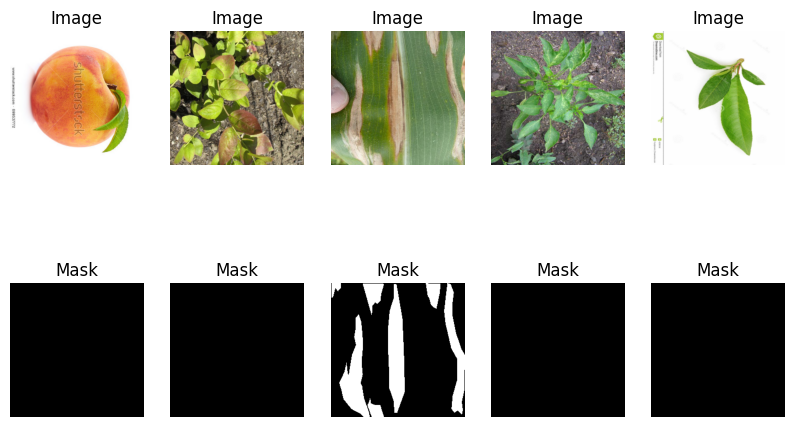

In [6]:
seg_dataset = SegDataset(csv_file='/kaggle/input/mlds-assignment-2/train.csv', root_dir= '/kaggle/input/mlds-assignment-2/train/train', transform=transform)
#train_test split
train_size = int(0.8 * len(seg_dataset))
val_size = len(seg_dataset) - train_size
train_seg_dataset, val_seg_dataset = torch.utils.data.random_split(seg_dataset, [train_size, val_size])
train_seg_dataloader = DataLoader(train_seg_dataset, batch_size=8, shuffle=True)
val_seg_dataloader = DataLoader(val_seg_dataset, batch_size=8, shuffle=True)
 
# Display a few images with their masks
def show_images(dataset, num_images=5):
    fig,axes = plt.subplots(2,num_images,figsize=(10, 6))
    for i in range(num_images):
        image,mask = val_seg_dataset[i]
        axes[0,i].imshow(v2.ToPILImage()(image))
        axes[0,i].set_title('Image')
        axes[0,i].axis('off')
        axes[1,i].imshow(v2.ToPILImage()(mask), cmap = 'gray')
        axes[1,i].set_title('Mask')
        axes[1,i].axis('off')
        
    plt.show()
 
show_images(seg_dataset, num_images=5)

In [7]:
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

In [8]:
from torchsummary import summary
import segmentation_models_pytorch as smp

In [9]:
# Define the model with reduced complexity
unet = smp.Unet(encoder_name='resnet50', encoder_weights='imagenet', classes=1, decoder_attention_type=None, decoder_use_batchnorm=True)
 
# Define loss function and optimizer
criterion = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)
 
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet.to(device)
criterion = criterion.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 253MB/s]


In [10]:
# Dice Score Function
def dice_score(outputs, masks):
    smooth = 1e-6
    outputs = torch.sigmoid(outputs)
    intersection = torch.sum(outputs * masks)
    union = torch.sum(outputs) + torch.sum(masks)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.item()
 
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
num_epochs = 30
 
# Initialize variables to store best validation loss and Dice score
best_val_loss = float('inf')
best_epoch = -1
best_dice = 0.0
 
# Training loop
for epoch in range(num_epochs):
    # Training
    unet.train()
    train_loss = 0.0
    for inputs, masks in train_seg_dataloader:
        inputs, masks = inputs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = unet(inputs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss
    train_loss = train_loss / len(train_seg_dataloader.dataset)
    
    # Validation
    unet.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for inputs, masks in val_seg_dataloader:
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = unet(inputs)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * inputs.size(0)
            val_dice += dice_score(outputs, masks) * inputs.size(0)
    
    # Calculate average validation loss and Dice score
    val_loss /= len(val_seg_dataloader.dataset)
    val_dice /= len(val_seg_dataloader.dataset)
    
    # Print epoch statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Dice Score: {val_dice:.4f}')

Epoch 1/30, Training Loss: 0.6319, Validation Loss: 0.6592, Validation Dice Score: 0.3408
Epoch 2/30, Training Loss: 0.5403, Validation Loss: 0.6795, Validation Dice Score: 0.2771
Epoch 3/30, Training Loss: 0.5023, Validation Loss: 0.6092, Validation Dice Score: 0.3473
Epoch 4/30, Training Loss: 0.5207, Validation Loss: 0.6431, Validation Dice Score: 0.3569
Epoch 5/30, Training Loss: 0.4922, Validation Loss: 0.5371, Validation Dice Score: 0.4194
Epoch 6/30, Training Loss: 0.4884, Validation Loss: 0.6107, Validation Dice Score: 0.3893
Epoch 7/30, Training Loss: 0.4382, Validation Loss: 0.8401, Validation Dice Score: 0.1599
Epoch 8/30, Training Loss: 0.4507, Validation Loss: 0.5227, Validation Dice Score: 0.4773
Epoch 9/30, Training Loss: 0.4289, Validation Loss: 0.4926, Validation Dice Score: 0.5074
Epoch 10/30, Training Loss: 0.4095, Validation Loss: 0.4464, Validation Dice Score: 0.5536
Epoch 11/30, Training Loss: 0.4266, Validation Loss: 0.4373, Validation Dice Score: 0.5192
Epoch 12

In [11]:
torch.save(unet.state_dict(),"segment.pth")

In [12]:
#unet.load_state_dict(torch.load("segment.pth"))

In [13]:
test_image_folder = '/kaggle/input/mlds-assignment-2/test/test/' 

## Inference

In [14]:
class TestDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
 
    def __len__(self):
        return len(self.data_frame)
 
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
 
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        
        # Split image into two parts along the width
        width = image.width
 
        if self.transform:
            image = self.transform(image)
 
        return image


In [15]:
segT = TestDataset(csv_file='/kaggle/input/mlds-assignment-2/test.csv', root_dir= '/kaggle/input/mlds-assignment-2/test/test', transform=transform)
test_seg_dataloader = DataLoader(segT, batch_size=8, shuffle=False)

In [16]:
def mask2rle(img):
    #https://www.kaggle.com/code/paulorzp/rle-functions-run-lenght-encode-decode
    #img: numpy array, 1 - mask, 0 - background
    #Returns run length as string formated
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,256)):
    #mask_rle: run-length as string formated (start length)
    #shape: (width,height) of array to return 
    #Returns numpy array, 1 - mask, 0 - background
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


In [17]:
def update_csv_with_segpredictions(unet_model, csv_path, test_folder, transform, device):
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Load the image
        img_name = row['id']  # Replace 'Image' with the actual column name
        img_path = os.path.join(test_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations if needed
        if transform:
            image = transform(image)
        image = image.unsqueeze(0)  # Add batch dimension

        # Move the image to the appropriate device
        image = image.to(device)

        # Perform inference
        with torch.no_grad():
            output = unet_model(image)

        # Convert the output to mask image
        mask = torch.sigmoid(output)
        mask = (mask > 0.5).float()  # Thresholding to obtain binary mask
        
        # Check if the image is completely black
        is_black = torch.all(mask == 0).item()
        
        # Update the DataFrame with the prediction
        if is_black:
            df.at[index, 'binary_pred'] = 0
            df.at[index, 'segmentation_pred'] = 'Healthy'  # Empty string for black images
        else:
            df.at[index, 'binary_pred'] = 1
            df.at[index, 'segmentation_pred'] = mask2rle(mask.cpu())  # Path to save mask image

            # Save the segmentation prediction
            #mask_image = transforms.ToPILImage()(mask.squeeze(0))  # Convert to PIL image
            #mask_image.save('/path/to/save/mask_image.png')  # Save the mask image

    # Save the updated DataFrame back to the CSV file
    #df.to_csv(csv_path, index=False)

# Update the CSV file with predictions
    return df

In [18]:
df_mask = update_csv_with_segpredictions(unet, '/kaggle/input/mlds-assignment-2/test.csv', '/kaggle/input/mlds-assignment-2/test/test', transform, device)

In [19]:
df_mask.head()

,id,binary_pred,segmentation_pred
0,Img_919.png,1.0,5657 1 5913 1 13406 1 13661 3 13706 2 13917 4 ...
1,Img_920.png,1.0,16172 2 17700 4 17953 8 18208 12 18322 5 18464...
2,Img_921.png,1.0,43654 2 43908 6 44163 8 44419 8 44675 9 44931 ...
3,Img_922.png,1.0,14735 1 14990 3 15245 5 15492 2 15500 6 15747 ...
4,Img_923.png,1.0,8299 2 8554 4 8810 3 20612 5 20620 17 20861 40...


In [20]:
df_mask.to_csv('submission.csv', index=False)

In [21]:
def update_csv_data(unet_model, csv_path, test_folder, transform, device):
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Load the image
        img_name = row['id']  # Replace 'Image' with the actual column name
        img_path = os.path.join(test_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations if needed
        if transform:
            image = transform(image)
        image = image.unsqueeze(0)  # Add batch dimension

        # Move the image to the appropriate device
        image = image.to(device)

        # Perform inference
        with torch.no_grad():
            output = unet_model(image)

        # Convert the output to mask image
        mask = torch.sigmoid(output)
        mask = (mask > 0.5).float()  # Thresholding to obtain binary mask
        
        # Check if the image is completely black
        is_black = torch.all(mask == 0).item()
        
        # Update the DataFrame with the prediction
        if is_black:
            df.at[index, 'model_pred'] = 0
        else:
            df.at[index, 'model_pred'] = 1

            # Save the segmentation prediction
            #mask_image = transforms.ToPILImage()(mask.squeeze(0))  # Convert to PIL image
            #mask_image.save('/path/to/save/mask_image.png')  # Save the mask image

    # Save the updated DataFrame back to the CSV file
    #df.to_csv(csv_path, index=False)

# Update the CSV file with predictions
    return df

In [22]:
df_data = update_csv_data(unet, '/kaggle/input/mlds-assignment-2/train.csv', '/kaggle/input/mlds-assignment-2/train_w_img_and_mask_seperated/train_imgs', transform, device)

In [23]:
df_data.head()

,id,binary_pred,segmentation_pred,model_pred
0,Img_0.png,1,12230 2 12485 3 12740 5 12764 6 12996 5 13019 ...,1.0
1,Img_1.png,1,24677 5 24933 7 25188 10 25443 13 25699 14 259...,1.0
2,Img_2.png,0,Healthy,1.0
3,Img_3.png,1,117 1 373 29 628 30 884 30 1141 29 1397 29 165...,1.0
4,Img_4.png,1,1 3 20 25 257 4 277 24 382 8 513 5 534 23 636 ...,1.0


In [24]:
# Calculate False Positives and False Negatives counts
FP_count = df_data[(df_data['binary_pred'] == 1) & (df_data['model_pred'] == 0)].shape[0]
FN_count = df_data[(df_data['binary_pred'] == 0) & (df_data['model_pred'] == 1)].shape[0]

# Calculate Accuracy, Precision, Recall and F1-score using the counts
accuracy = (df_data.shape[0] - (FP_count + FN_count)) / df_data.shape[0]
precision = (df_data.shape[0] - FP_count) / df_data.shape[0]
recall = (df_data.shape[0] - FN_count) / df_data.shape[0]
f1_score = 2 * precision * recall / (precision + recall)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1_score:.2f}')


Accuracy: 0.62
Precision: 1.00
Recall: 0.63
F1-score: 0.77
